In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [3]:
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [5]:
from torchvision import datasets, transforms

In [6]:
data_path = './cifar10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [7]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,\
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [8]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10
              if label in [0, 2]]

In [9]:
img, _ = cifar2[0]

In [10]:
output = conv(img.unsqueeze(0))

In [11]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

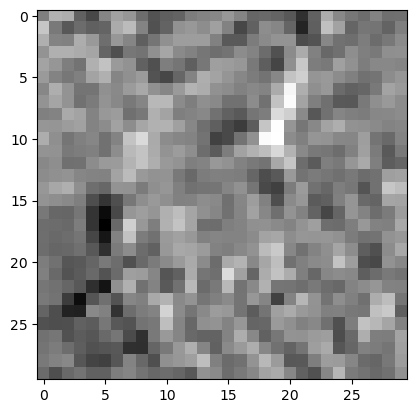

In [12]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

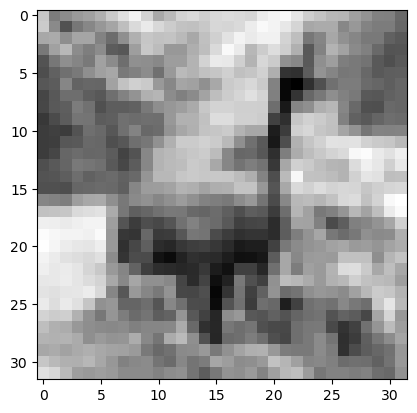

In [13]:
plt.imshow(img[0], cmap='gray')
plt.show()

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [15]:
with torch.no_grad():
    conv.bias.zero_()

In [16]:
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

In [17]:
output = conv(img.unsqueeze(0))

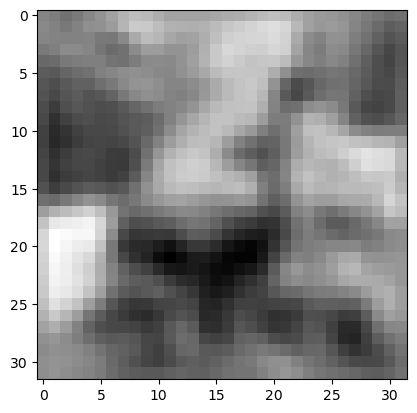

In [18]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    
    conv.bias.zero_()

In [20]:
output = conv(img.unsqueeze(0))

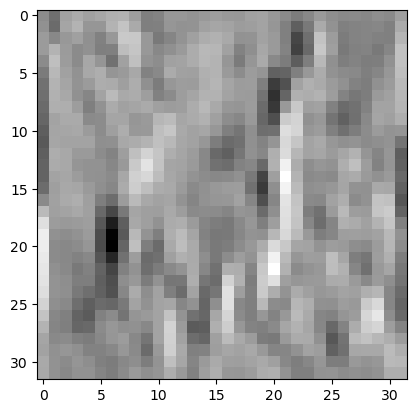

In [21]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

In [22]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

In [23]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [24]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    #...
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [25]:
numel_list = [p.numel() for p in model.parameters()]

In [26]:
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = Net()

In [29]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [30]:
import torch.nn.functional as F

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [32]:
model  = Net()

In [33]:
model(img.unsqueeze(0))

tensor([[-0.1223, -0.1144]], grad_fn=<AddmmBackward0>)

In [34]:
import datetime

In [35]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch==1 or epoch%10==0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)))

In [36]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [37]:
model = Net()

In [38]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [39]:
loss_fn = nn.CrossEntropyLoss()

In [56]:
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    loss_fn=loss_fn,
    model = model, 
    train_loader=train_loader)

2023-02-11 15:36:39.245334 Epoch 1, Training loss 0.5517996976709669
2023-02-11 15:51:10.675330 Epoch 10, Training loss 0.3454340915581223
2023-02-11 16:07:36.809295 Epoch 20, Training loss 0.29372993567187317


KeyboardInterrupt: 

In [40]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle=False)

In [41]:
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

In [42]:
validate(model, train_loader, val_loader)

Accuracy train: 0.50
Accuracy val: 0.50


In [43]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [44]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [45]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training on device {device}.')

Training on device cuda.


In [46]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch==1 or epoch%10==0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train/len(train_loader)))

In [47]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [48]:
model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [49]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-02-11 16:40:21.129205 Epoch 1, Training loss 0.6062279301843826
2023-02-11 16:40:25.204406 Epoch 10, Training loss 0.3387602348426345
2023-02-11 16:40:29.880721 Epoch 20, Training loss 0.30173210771220504
2023-02-11 16:40:34.628424 Epoch 30, Training loss 0.2760330359837052
2023-02-11 16:40:39.289819 Epoch 40, Training loss 0.2546543381206549
2023-02-11 16:40:43.922707 Epoch 50, Training loss 0.23570700435881403
2023-02-11 16:40:48.610808 Epoch 60, Training loss 0.2188452397277401
2023-02-11 16:40:53.268525 Epoch 70, Training loss 0.20452862973235975
2023-02-11 16:40:57.967228 Epoch 80, Training loss 0.1916033423915031
2023-02-11 16:41:02.683271 Epoch 90, Training loss 0.17432036692169822
2023-02-11 16:41:07.268556 Epoch 100, Training loss 0.16473498252356888


In [50]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [51]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path +'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

In [52]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle=False)

In [54]:
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

In [55]:
validate(model, train_loader, val_loader)

Accuracy train: 0.87
Accuracy val: 0.87


In [56]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [57]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [58]:
model = NetWidth()

In [59]:
sum(p.numel() for p in model.parameters())

38386

In [60]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.pararmeters())
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch==1 or epoch%10==0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)))

In [61]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [62]:
class NewBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8*8*n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [63]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [64]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [65]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out+x

In [66]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out